# AiMotion : réseaux de neurones convolutionnels appliqués à la reconnaisance d'émotions en temps réel


L'idée du projet est de proposer un programme permettant à l'aide d'un réseau de neurones convolutionels (CNN) d'interpreter l'expression faciale d'un sujet, acquise par webcam, en une émotion de joie ou de tristesse.

Le présent notebook se structure en 3 partie.

1. La première partie met en évidence la construction globale du projet et reponds, ce faisant, aux points et questions suivantes:
    * Quelles sont les grandes lignes des fondements théoriques ayant permis AiMotion ?
    * Comment s'articule le projet en terme de conception logicielle ?
    * Conséquement, quelles sont les ressources en terme de librairies utilisées et comment se démarque notre contribution originale dans ce projet ?
    * Quels sont les performances et les résultats du projet sur la détection d'émotion en temps-reel ?
    * Quelles sont les principales difficultés rencontrés lors de la mise en oeuvre de ce projet, classées par ordre de "chronophagie" ?
    
    
2. La deuxième partie du notebook exposera, pas à pas et de manière commentée, le code permettant l'apprentissage de la detection des émotions joie/triste à notre CNN. **Dans cette partie, les cellules ne doivent pas être exécutées**, elle permettent seulement de mettre en évidence notre travail déjà encapsulé dans le fichier .pth d'architectureset de poids de notre réseau de neurones pré-entrainé.

3. **La troisième partie du notebook permettra l'éxécution facilitée du projet** à l'aide de l'appel d'une seule fonction. Ce faisaint, nous expliqueront son fonctionnement en tant que "nerf optique et oeil" de notre CNN. De plus, nous profiterons de l'occasion pour décrire l'algorithme de Haar-Viola-Jones sur lequel se base cette fonction de "wrap-up" du projet.
    
 




# Partie 1:  Du biomimétisme au code informatique

## A) Vue d'ensemble d'AiMotion

![Vue d'ensemble du projet](img_notebook/img1.png)

* L'inspiration biomimétique est au coeur du projet.
* L'action combinée des lobes occipitale et temporal permet l'acquisition et l'interprétation des influx nerveux optiques transmis par l'oeil.
* Ai_Motion se structure sur ce modèle en "feedant" un flux d'images en continu issue de la webcam, transformé et ajusté , dans un CNN pré-entrainé sur des données l'autorisant à apprendre le mapping entre expression du visage et émotions de joie ou de tristesse. 

## B) Éléments Théoriques

![Représentation d'un CNN](img_notebook/img3.jpeg)

Le CNN est un sous-ensemble des architectures neuronales plus générale permettant le mapping entre features d'une donnée et sa classe.

Il s'avère le CNN est une architecture conçu spécifiquement pour s'adapter de manière performantes aux données de type image et permmettre ainsi un meilleur mapping entre features, dans notre cas la feature de 'haut-niveau' sera l'expression faciale, et la classe, qui est ici l'émotion de joie ou de tristesse.

* L'architecture d'un CNN se décompose en un ensemble Feature Learning...
    1. "Ensemble Feature Learning' spécifique au CNN et donc au traitement des problème de Deep Learning sur des images: les deux éléments phares de ce sous-ensemble sont les transformations "convolution" et "pooling";
    2. La transformation de convolution est particulièrement adaptée puisque elle permet de gérer la "haute dimensionnalité" des répresentation informatique des images en tenseur, ici 32 par 32 par 32. ![DCNN1](img_notebook/img4.png)                                        Elle consiste seulement au dot product entre un filtre ( tenseur de paramètres à optimisées via gradient descent comme pour des NN classiques) et une portion de l'image originelle. Cette opération est répétée sur toutes où l'on peut possiblement projeter le filtre sur l'image jusqu'a obtenir une matrice donné appelée feature map.           ![DCNN2](img_notebook/img5.png)                                            On repète ce procédé avec différent filtres pour obtenir une couche de convolution entierement paramétrée. 
    3. La transformation dite Pooling permet de rédure la dimensionnalité de la réprésentation de l'image réduisant ainsi le nombre de paramètre et donc la puissance calculatoire necessaire. Cette transformation s'applique sur chaque feature map indépendamment. Le Max Pooling est une approche communément utilisée dont voici le fonctionnement.               
![DCNN3](img_notebook/img6.png)
    
    
* ... et un ensemble de Classification:
    1. Cet esemble est complètement analogue aux NN classiques, sur chaque couches des neurones combines des tranformations paramétrées linéaires en entrée et non-linéaire en sortie (Relu, Sigmoïde etc)
    ![DCNN4](img_notebook/img7.png)
    2. Une des différences clés c'esr que chaque neurones recoit une transformation linéaire de toutes les features des la couche précédente et donc des données alors que nous venons de montrer que pour la couche de convolution , chaque feature map ne reçoit qu'une partie de l'information de la donnée en entrée du CNN




## C) Conception du code 

### i) Entrainement d'un CNN restnet50 via tranfert learning

![Resnet50](img_notebook/img8.png)

* On entraine nos données sur un dataset issue d'une compétition Kaggle. Celui-ci contient des données images d'expression du visage en grayscale labélisées pour 7 émotions. On a réduit l'ensemble pour se concentrer dans ce projet sur la joie/tristesse


* Pour optimiser la performance de notre CNN, **notre stratégie d'optimisation** est d'utiliser la méthode du transfert learning. Celle-ci consiste à utiliser un modèle déjà pré-entrainer sur des données.Ici en l'occurence on utlise un modèle d'architecture resnet50 qui déjà été entrainer sur plus de 1.5M d'images à catégoriser plus d'un milliers de classe. L'idée est de tirer profit de cette connaissance accumulée par le modèle, nottament sur les premieres couches du CNN qui contiennent les representation de 'bas niveau' du contenu d'une image, pour ne l'entrainer que sur les dernieres couches en y spécifiant cette fois nos classes propres i.e joie/tristesse. On fine-tune les hyper paramètres du modeles notamment grace à la méthode des " taux d'apprentissage cycliques de Leslie Smith" implémentée dans fastai.


* En fin de ce processus, on obtient un fichier pth contenant les données d'architecture du modèle ainsi que les poids ajustés permettant de répondre au mieux à notre problème de classification. Ce modèle s'integrera dans le code flow plus général de Ai_Motion.


### ii) Code Flow Global

![Code Design](img_notebook/img2.png)


* Le code flow du projet suit le schéma ci-dessus, et il ressort que le projet s'articule autour de **deux ressources principales** : 
    1. **OpenCV** spécialisée en computer vision et en traitement de l'image
    2. **fastai** framework de Machine Learnig construit au-dessus de pytorch et qui dispose d'une conception de ses fonctionnalités construite autour des différents 'use-case' du ML, la 'vision' nous interessera plus particulierement

* Le flow de notre code suit le cours suivant :
    1. Acquisition du flux vidéo webcam avec OpenCV
    2. Extraction de la frame en cours
    3. Utilisation de l'algorithme de Haar-Viola-Jones pour detecter le visage du sujet
    4. Lorsque détection est faite, on rogne le visage et on lui applique un filtre GrayScale
    5. On feed cette image transformée dans un format adéquate dans le CNN pour prédiction
    6. On renvoit la prédiction sur la frame d'origine extraite, au moyen d'un affichage clair
    7. On réintegre la frame dans un flux vidéo que le renvoi à l'utilisateur en 'temps réel' modulo le temps des différentes étapes de calculs

* Notre **Contribution Originale** tient justement à la conception et à l'implémentation de la fonction qui renferme toutes ces étapes.Une description précise de notre travail, combinant les deux librairie dans  ce qui constitue la colonne vertébrale d'Ai Motion se trouve en Partie 3 du notebook. La phase d'entrainement du modèle a également réquirit une vigilance et une prévoyance toute particulière dans la mise en oeuvre du projet.



## C) Quelques Tribulations...

 C'est tout naturellement que l'entreprise de la mise sur pieds d'une telle fonction fut la cause de nos soucis les plus chronophages mais également les plus riches d'enseignement. Les voici classés par ordre de chronophagie, en précisant à chaque fois ce que l'on a pu y retirer.

1. Difficulté de se confronter pour la première fois à des documentations de librairies informatique et à bien comprendre le fonctionnement des fonctionnalités que l'on veut utiliser, surtout pour openCV. Au début, on attendaient de tout comprendre avant de se lancer... ce qui evidemment n'arrivait pas.. On a appris au fur et à mesure à se lancer, faire des erreurs, les corriger et iterer sur ça.



2. Gros problème sur la représentation informatique des images entre l'étape de capture et et le format necésaire pour la prédiction. La representation PIL (Python Image Library) se voyait détruire/biaser de son information lorque l'on essayait de la convertir en tenseur pytorch pour la feed dans le CNN. En résultait des prédictions completement faussées et toujours biasée vers la meme émotions..Notre diagnostic premier etait celui des faibles performances de notre CNN, ce qui nous a valu de l'entrainer avec une technique dite de Data Augmentation (ajoute du bruit dans les données en les transformant, augmentant ainsi son habitude pour des données nouvelles et perturbée). Les résultats furent meilleurs sur le set de validation mais pas avec openCV... C'était une étape assez difficile car la solution était loin d'etre evidente et simple.. Il a fallu multiplier les tests de prédictions "à la main" sur différents formats, analyser la transformation effectuée sur les images et la visualiser, comparer par exemple simplement le resultat sur une capture et le resultat sur un objet image converti avec open_cv.. Meme l'éventail large des fonctions clés en main de fastai n'as pas suffit et il a fallu tréfouiller la documentation de fastai pour comprendre les différentes transformations sur la réprésentation et trouver enfin la bonne façon de faire et les bons paramètres. Evidemment cela nous a tout suite fait prendre conscience de qualités nécessaires au programmeur : la persevérance tout autant que la bonne compréhension des objets qu'il manipule



3. Difficulté avec le 'OK" sur le test unitaire. Ceci nous a revélé plein de manquement sur notre code, notamment la gestion du flow openCV qui n'était pas du tout optimal. Par exemple, une des solutions temporaire pour la fonction principale était d'ecrire les frames une à une sur le disque pour ensuite les reconvertir au bon format et les utiliser en prédiction pour éviter le soucis évoqué en point 2... Ceci nous a fait comprendre de votre insistance à l'utilisation de ces tests qui semblaient au départ saugrenus mais qui font désormais parti de nos réflèxes et bonne pratiques tant leurs gain en compréhension et en efficaité du code son important.




## C) Résultats

Obtention d'une accuracy de **88%** sur le modèle final et d'une rapidité convenable de la **detection fiable des visages sur un flux de webcam** en 'temps presque reel'.








# PARTIE 2 : Apprentissage de l'interprétation des expressions faciales de joie et de tristesse

**Rappel: dans cette partie, les cellules ne doivent pas être exécutées. Elles mettent seulement en évidence notre travail**

## Imports

In [1]:
from fastai import *
from fastai.vision import *

 ## Acquisition des données

### Création de l'objet ImageDataBunch renfermant notre dataset
* Détecte directement le jeu d'entrainement et de validation des données séparés en deux dossiers *train* et *valid*
* Labellisation des images sur les différentes émotions faite de par la présence des données dans des sous-répertoire éponymes
* *.normalize(imagenet_stats)* permet de normaliser directement les données lors de l'import, bonne pratique du Deep Learning pour permettre un apprentissage plus performant.

In [41]:
path = 'utils/'
data =ImageDataBunch.from_folder(path,size=48).normalize(imagenet_stats)

### Vérification de la bonne prise en compte de nos classes d'émotions

In [42]:
data.classes

['Happy', 'Sad']

### Visualisation de l'objet renfermant notre dataset
* Les données sont bien séparés en deux sous-ensemble *train* et *valid*
* Confirmation que nos images sont bien prise en compte comme des _tenseurs pytorch grayscale_ de shape (3, 48, 48)
* Dans chaque sous ensemble de l'objet, le vecteur liste *x* correspond aux données elle-même, _y_ aux labels associés
* *Path* renvoie au chemin d'accès de notre dataset sur le disque

In [43]:
data

ImageDataBunch;

Train: LabelList (11985 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
Happy,Happy,Happy,Happy,Happy
Path: utils;

Valid: LabelList (1548 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
Happy,Happy,Happy,Happy,Happy
Path: utils;

Test: None

### Visualisation de notre dataset
* Visualisation d'un segment aléatoire de nos données dans une matrice carrée d'ordre 3
* On peut vérifier qu'a chaque image est bien associé  correctement son label

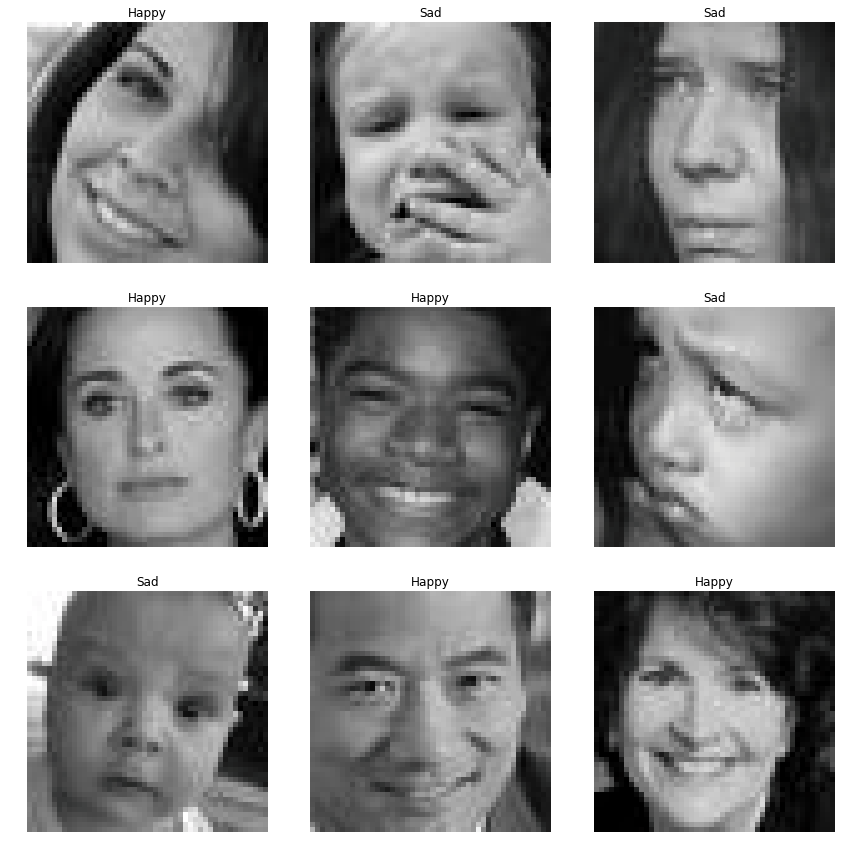

In [44]:
data.show_batch(rows=3)

## Transfert Learning sur une architecture Resnet50

## Objet create_cnn
* Renferme l'architecture de notre modèle et permet de précharger les poids de restnet50
* On passe comme argument l'ImageDataBunch precedemment créé afin d'initialiser les derniers couches du CNN pour acceuillir nos deux classes d'interet en sortie finale : happy/sad


In [55]:
learn = cnn_learner(data,models.resnet50,metrics=accuracy)

### Utilisation de la méthode de Smith  pour l'optimisation du learning rate

In [56]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


### On séléctionne le range de learning rates sur lequel la perte est la plus décroissante

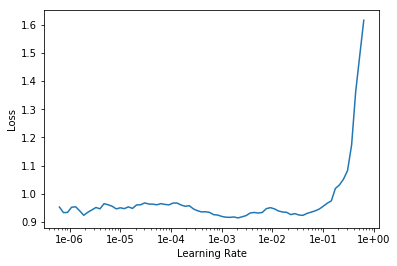

In [57]:
learn.recorder.plot()

### On entraine le modèle en prenant en compte le range de  l'hyperparametre 

* On utilise le fit dit one_cycle plus performant
* On fait 7 cycles sur les données c'est à dire 7 épochs
* Sur nos dizaines de tests différents, on finit par trouvé 88% d'accuracy sur le set de validation. 
* le nom du model sauvegarder avec cette performance est 'model-1-resnet50' disponible dans utils/models pour toute assertion des résultats

In [ ]:
learn.fit_one_cycle(7, max_lr = slice(1e-05,7*1e-04))

### Chargement de l'objet permettant d'analyser les performances de notre algorithmes

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

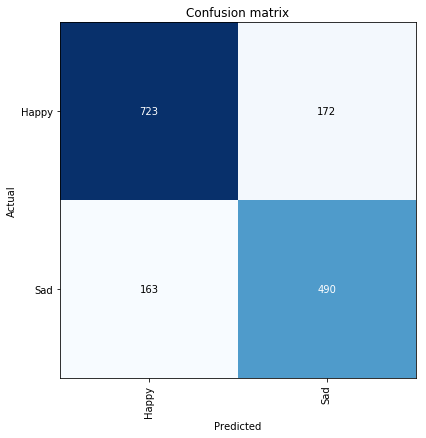

In [35]:
# Ceci ne correspond pas à la confusion matrix de notre model définitif...
# Il y'a malheuresement interruption du kernel
interp.plot_confusion_matrix(figsize=(6,6))

In [36]:
interp.most_confused()

[('Happy', 'Sad', 172), ('Sad', 'Happy', 163)]

# PARTIE 3 : Exécution du projet

## A) Description du fonctionnement de detect_emotions()

* Detect_emotions correspont à la fonction fondamentale de notre projet évoquée dans le Code Flow


In [ ]:
import cv2
import numpy as np
from fastai.vision import ImageDataBunch, get_transforms, imagenet_stats, models, cnn_learner, pil2tensor, Image


def detect_emotions(Webcam_Usage=True,Video_Source='',Enable_Emoji=True):
    
    ###Chargement du modèle de detection des émotions et des données d'architecture associées


    
    '''Paramètre correspondant au chemin d'accès des données permettant dans ce cas de preciser dans l'objet ImageDataBunch
    la structure de notre modele, notamment le nombre de classes d'émotions à distinguer '''
    emotion_model_path = './'

   
    # Chargement des informations sur l'architecture du modèle
    data =ImageDataBunch.from_folder(emotion_model_path,ds_tfms=get_transforms(),size=48).normalize(imagenet_stats)
    emotion_labels = data.classes
    learn = cnn_learner(data, models.resnet50,pretrained=False)
    # Chargement des poids de notre modèle pré-entrainé sur nos données coresspondant à cette architecture (88% de précision sur la discrimantion Happy/Sad sur l'ensemble de validation)
    learn.load('model-resnet50-1')
    
 
    ### Flux d'images entrant dans le réseau de neurones

    # Chargement de l'algorithme de la cascade de HAAR,technique classique de computer vision,permettant de déjà préselectionner les visages sur le flux d'images entrant

    haar_cascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

    # Parametre définissant le rognage effectué sur les visages préselectionnés, permettant de meilleurs performances de detection
    crop_param = (20, 40)

    # Paramètre de chemin d'accès utilisé pour afficher l'émoji correspondant à l'émotion prédite sur le visage : 
    emoji_path = './emoji'
    
    # Paramètres utilisés pour effectuer le test unitaire de detect_emotions()
    test_pred = None
    

    # Fenetre de capture
    cv2.namedWindow('AI_MOTION')
    
    # Selection du type de flux, webcam ou vidéo en local
    video_feed_capture = None
    if Webcam_Usage:
        # 0 est par défaut dans CV2 le paramètre corespondant à la webcam
        video_feed_capture = cv2.VideoCapture(0) 
    else:
        # Source Vidéo
        video_feed_capture = cv2.VideoCapture(Video_Source) 

    # Demarrage du flux d'images d'entrant
    while video_feed_capture.isOpened():

        # Extraction de  l'état de lecture et de la frame en cours
        r , frame = video_feed_capture.read()

        # Si la lecture est faites sans encombre, r= True , on peut proceder à la suite du programme
        if r:

            # Par défaut, la frame est en RGB, on la converti en image "niveaux de gris" car c'est ce sur quoi notre modèle a été entrainer
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            #Extraction des visages present sur la gray_frame grace à l'algorithme de HAAR précedement chargé, nous retourne un itérable de coordonnées spatiales dans la gray_frame correspondantes
            
            visages = haar_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5,
                    minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

            # Grace à chaque coordonnées des visages detectés, on leur applique le rognage spécifié precedemment et les envoient dans le réseau de neurones pour detection
            for visage_coordinates in visages:

                # Extraction des coordonées du visage en cours de traitementn, h étant la hauteur et w la largeur du rectangle correspondant au visage
                X, Y, w, h = visage_coordinates

                # Rognage et extraction de l'image 'niveau de gris' traité du visage en cours de traitement
                x_d, y_d = crop_param
                x1, x2, y1, y2 = (X - x_d, X + w + x_d, Y - y_d, Y + h + y_d)
                cp_visage = gray_frame[y1:y2, x1:x2]

                # Conversion de l'image dans une représentation non biasée par cv2.COLOR_BGR2GRAY et PIL et compréhensible par pytorch et donc fastai 
                
                cp_visage = Image(pil2tensor(cp_visage,np.float32).div_(255))


                # Appel du modèle chargé pour obtenir sa prédiction en terme de classe d'émotion ainsi que sa confiance sur cette prédiction en terme de probabilité
                emotion_pred_class, pred_idx, outputs = learn.predict(cp_visage)
                emotion_prob = float(outputs[np.argmax(outputs)])

                # Assignation de la prediction faite a une variabLE nous permettant d'éffectuer un test unitaire
                test_pred = str(emotion_pred_class)
                
                # Affichage,sur la frame RGB d'origine, du rectangle issu de la HAAR cascade sur le visage detecté, ainsi que sur celui-ci l'émotion prédite
                cv2.rectangle(img=frame,pt1=(X, Y),pt2=(X + w, Y + h),color=(0, 0, 0),thickness=2)
                cv2.putText(frame,str(emotion_pred_class),(X, Y),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0, 128, 0),2)
                # Affichage, en bas à gauche de la frame, de la confiance que le modèle a en sa prédiction 
                cv2.putText(frame,str(emotion_pred_class) + ' Probability  ' + str(round(emotion_prob,3)*100)+"%",(50,600),cv2.FONT_HERSHEY_SIMPLEX,1,(255, 255, 255),3)

                
                #Affichage, sur une fenetre annexe, de l'émoji correspondant à l'émotion prédite sur le visage en traitement , dans le cas ou Enable_Emoji est vrai et que la webcam est utilisée
                
                if (Enable_Emoji and Webcam_Usage) :

                    if str(emotion_pred_class) == 'Happy':
                        
                        emoji = cv2.imread(emoji_path+'/happy.png',1)
                        cv2.namedWindow('emoji', cv2.WINDOW_NORMAL)
                        cv2.imshow('emoji',emoji)
                    
                    else:
                        
                        emoji = cv2.imread(emoji_path+'/sad.png',1)
                        cv2.namedWindow('emoji', cv2.WINDOW_NORMAL)
                        cv2.imshow('emoji',emoji)
                    
                    
            # Affichage de tous les traitements effectués,à chaque nouvelle frame, sur la frame originelle dans la fenetre principale 'AI_MOTION'    
            cv2.imshow('AI_MOTION', frame)
            # Definition d'une escape key permetant de sortir de la boucle crop-detection-affichage
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        #Si l'état de lecture retourne False, on sort de la boucle while d'ouverture de la capture du flux d'image        
        else:
            break        

    # Fin de la capture du flux d'image et fermeture des fenetres emoji et AI_MOTION       
    video_feed_capture.release()
    cv2.destroyAllWindows()
    # La fonction retourne la valeur de test_pred, correspondant à la prédiction sur la dernière frame du dernier visage, a des fins de tests
    return test_pred













## B) Description de l'algorithme de Haar-Viola-Jones

![haar](img_notebook/img9.png)

* La méthode de Viola et Jones permet la reconnaissance faciale en discrétisant une image à l’aide d’une série de rectangles adjacents. Pour chacun d’eux, il faut calculer l’intensité moyenne des pixels qui s’y trouvent. On définit alors les caractéristiques pseudo-Haar, qui sont calculées par la différence des sommes de pixels de deux ou plusieurs zones rectangulaires adjacentes. 

* Nous allons procéder de façon similaire en changeant l’échelle de la décomposition de l’image et donc travailler sur des rectangles de plus en plus grands. Viola et Jones prennent ainsi un facteur multiplicatif de 1,25 à chaque changement d’échelle, jusqu'à ce que la fenêtre couvre la totalité de l'image.

* Ils utilisent ensuite un algorithme de boosting, adapté d’AdaBoost.  Ce classificateur dit fort utilise la combinaison optimale de classificateurs faibles tels que des arbres de décision : il prend en compte à chaque nouvelle itération un nouveau classificateur faible. 

* Cette méthode risque d’induire une grande complexité du fait du fait des différents changements d’échelle. Viola et Jones introduisent la méthode dite des « cascades des classifieurs (ou classificateurs) » pour éviter les calculs inutiles et réduire la complexité. Ils veulent être capables d’identifier les zones où l’objet recherché ne se trouve vraisemblablement pas, les extraire du champ spatial d’investigation ai ainsi mieux se concentrer sur les parties de l’image où il a une probabilité non négligeable de se trouver. En  partant des classificateurs les plus simples lorsqu’on construit l’algorithme de boosting, on peut rejeter très rapidement la grande majorité des exemples négatifs.

## C) Espace d'éxécution du projet

* Il suffit d'éxecuter le programme emotions.py inclut dans le dossier utils à l'aide du terminal
* Appuyer sur la touche q vous permettra de quitter normalement le programme

## D) Procédure pour le test unitaire

* Il suffit de lancer le programme test_unitaire.py présent dans le répertoire
* Un warning s'affiche du au fichier model temporaire que fastai crée lorque l'on appelle cnn_learner, mais mis à part cela tout est OK selon unittest